In [182]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [183]:
df=pd.read_csv('/content/IMDb Movies India.csv',encoding='latin-1')

In [217]:
df.head(5)

,Name,Year,Duration,Rating,Votes,Director_Avg_Rating,Genre_Avg_Rating,Actor 1_Popularity,Actor 2_Popularity,Actor 3_Popularity
0,,1987.012215,128.126519,5.841621,1938.520394,5.770811,5.928067,2,35,2
1,#Gadhvi (He thought he was Gandhi),2019.000000,109.000000,7.000000,8.000000,7.000000,5.928067,2,1,1
2,#Homecoming,2021.000000,90.000000,6.300000,16.200000,6.300000,5.928067,3,3,1
3,#Yaaram,2019.000000,110.000000,4.400000,35.000000,4.400000,5.928067,5,1,2
4,...And Once Again,2010.000000,105.000000,4.700000,76.800000,6.100000,5.928067,6,9,3


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [186]:
df.describe()

,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


In [187]:
df.shape

(15509, 10)

In [188]:
df.isna().sum()

,0
Name,0
Year,528
Duration,8269
Genre,1877
Rating,7590
Votes,7589
Director,525
Actor 1,1617
Actor 2,2384
Actor 3,3144


In [189]:
df['Votes'] = df['Votes'].astype(str).str.replace(',', '')
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')
df['Year'] = df['Year'].astype(str).str.extract(r'(\d{4})')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Duration'] = df['Duration'].astype(str).str.extract(r'(\d+)')
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

In [190]:
categorical_cols = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

In [191]:
encoders = {}
categorical_cols = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

In [192]:
numeric_cols = ['Year', 'Duration', 'Votes', 'Rating']
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [193]:
print(df[numeric_cols].isnull().sum())

Year        0
Duration    0
Votes       0
Rating      0
dtype: int64


In [194]:
df.groupby('Director').size()

,0
Director,
0,1
1,18
2,1
3,5
4,1
...,...
5934,7
5935,2
5936,2


In [195]:
for col in ['Genre', 'Director']:
    print(f"\nTop 10 most frequent values for {col}:\n{df[col].value_counts().head(10)}")


Top 10 most frequent values for Genre:
Genre
299    2780
484    1877
0      1289
479     779
460     708
361     524
181     495
29      455
313     418
409     322
Name: count, dtype: int64

Top 10 most frequent values for Director:
Director
5549    525
2034     58
2304     57
855      50
2696     48
2850     47
3124     46
1342     46
2936     44
828      44
Name: count, dtype: int64


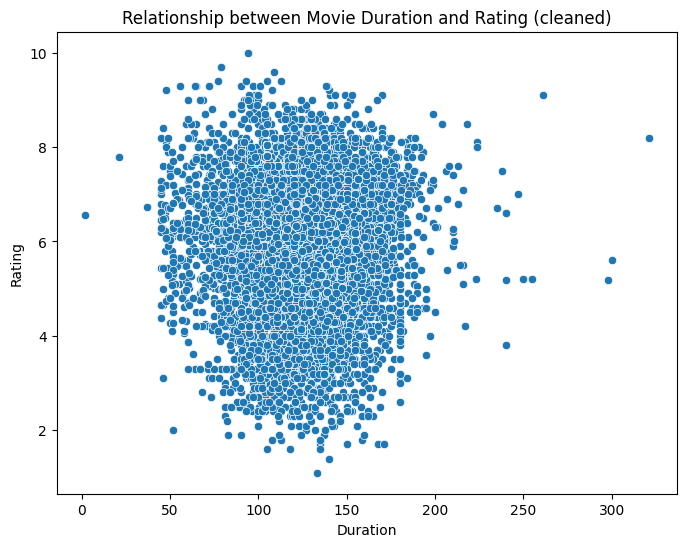

In [196]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Duration', y='Rating',data=df)
plt.title('Relationship between Movie Duration and Rating (cleaned)')
plt.xlabel('Duration')
plt.ylabel('Rating')
plt.show()

In [197]:
director_avg_rating = df.groupby('Director')['Rating'].mean()
df['Director_Avg_Rating'] = df['Director'].map(director_avg_rating)

In [198]:
genre_exploded = df['Genre'].astype(str).str.split(', ').explode()
genre_avg_rating = df[['Genre', 'Rating']].copy()
genre_avg_rating['Genre'] = genre_exploded.reset_index(drop=True)
genre_avg_rating = genre_avg_rating.groupby('Genre')['Rating'].mean()

In [199]:
def calculate_genre_avg(genre_int):
    genre_str = encoders['Genre'].inverse_transform([genre_int])[0]

    if not genre_str or genre_str == 'Unknown':
        return df['Rating'].mean()
    genres = genre_str.split(', ')
    ratings = [genre_avg_rating.get(g, df['Rating'].mean()) for g in genres]
    return sum(ratings) / len(ratings)

df['Genre_Avg_Rating'] = df['Genre'].apply(calculate_genre_avg)

In [200]:
for actor_col in ['Actor 1', 'Actor 2', 'Actor 3']:
    actor_counts = df[actor_col].value_counts()
    df[f'{actor_col}_Popularity'] = df[actor_col].map(actor_counts)

In [201]:
df_with_names = df.copy()

In [202]:
df = df.drop(['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3'], axis=1)

In [203]:
print(df.head())

                                 Name         Year    Duration    Rating  \
0                                      1987.012215  128.126519  5.841621   
1  #Gadhvi (He thought he was Gandhi)  2019.000000  109.000000  7.000000   
2                         #Homecoming  2021.000000   90.000000  6.300000   
3                             #Yaaram  2019.000000  110.000000  4.400000   
4                   ...And Once Again  2010.000000  105.000000  4.700000   

         Votes  Director_Avg_Rating  Genre_Avg_Rating  Actor 1_Popularity  \
0  1938.520394             5.770811          5.928067                   2   
1     8.000000             7.000000          5.928067                   2   
2    16.200000             6.300000          5.928067                   3   
3    35.000000             4.400000          5.928067                   5   
4    76.800000             6.100000          5.928067                   6   

   Actor 2_Popularity  Actor 3_Popularity  
0                  35               

In [204]:
features = ['Year', 'Duration', 'Votes', 'Genre_Avg_Rating', 'Director_Avg_Rating',
            'Actor 1_Popularity', 'Actor 2_Popularity', 'Actor 3_Popularity']

In [205]:
X = df.drop(['Rating', 'Name'], axis=1)
y = df['Rating']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [207]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

In [208]:
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

In [209]:
best_rf = grid_search.best_estimator_

In [210]:
y_pred = best_rf.predict(X_test)
print("Model Performance:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

Model Performance:
Mean Squared Error: 0.40
Mean Absolute Error: 0.37
R2 Score: 0.69


In [211]:
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R2 Scores: {cv_scores}")
print(f"Average CV R2 Score: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Cross-Validation R2 Scores: [0.67657886 0.69329421 0.6995076  0.68230872 0.67599859]
Average CV R2 Score: 0.69 ± 0.01


In [218]:
def predict_movie_rating(movie_name, df, model, features):
    movie = df[df['Name'].str.lower() == movie_name.lower()]
    if movie.empty:
        return f"Movie '{movie_name}' not found in the dataset."

    movie_features = movie[features].reindex(columns=X_train.columns)

    rating = model.predict(movie_features)[0]
    return f"Predicted rating for '{movie_name}': {rating:.1f}"

while True:
    movie_name = input("Enter movie name (or 'exit' to quit): ")
    if movie_name.lower() == 'exit':
        break
    prediction = predict_movie_rating(movie_name, df, best_rf, features)
    print(prediction)

Enter movie name (or 'exit' to quit): #Gadhvi (He thought he was Gandhi)
Predicted rating for '#Gadhvi (He thought he was Gandhi)': 7.0
Enter movie name (or 'exit' to quit): #Homecoming
Predicted rating for '#Homecoming': 6.3
Enter movie name (or 'exit' to quit): #Yaaram
Predicted rating for '#Yaaram': 4.3
Enter movie name (or 'exit' to quit): exit
